# Clasificador de Desechos 🗑️

🧑🏽‍💻 **Said Ortigoza Trujillo, A01707430**

### Conexión con Google Drive y visualización del directorio

In [67]:
from google.colab import drive
drive.mount('/content/drive')

# Path en Drive de la carpeta del dataset
%cd "/content/drive/MyDrive/TEC/Semestre 8/Waste Classification"
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/TEC/Semestre 8/Waste Classification
Dataset  Test  Train  Validation


### Importar las librerías necesarias

**tensorflow (tf):** Proporciona herramientas para construir, entrenar y desplegar modelos de redes neuronales.

**pandas (pd):** Ofrece estructuras de datos y funciones para trabajar con datos tabulares y series temporales de manera eficiente.

**numpy (np):** Proporciona soporte para matrices multidimensionales y una amplia gama de funciones matemáticas para operar con estas matrices de manera eficiente.

**matplotlib.pyplot (plt):** Para crear gráficos, diagramas y trazados para explorar y comunicar datos.

**os:** Se utiliza para manipular archivos, directorios y rutas de archivos.

**shutil:** Se utiliza para copiar, mover y eliminar archivos y directorios.

**random:** Se utiliza para generar secuencias de números aleatorios y para mezclar aleatoriamente elementos de una lista.

**tensorflow.keras.preprocessing.image.ImageDataGenerator:** Se utiliza para cargar y preprocesar imágenes para su uso en modelos de redes neuronales.

**glob:** Se utiliza para buscar y listar archivos en un directorio.

**PIL.Image:** Se utiliza para abrir, manipular y guardar imágenes en varios formatos de archivo.

In [64]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers

from glob import glob
from PIL import Image

### Directorios del dataset inicial, entrenamiento, prueba y validación

In [ ]:
# Rutas de las carpetas
base_dir = 'Dataset'
train_dir = 'Train'
test_dir = 'Test'
val_dir = 'Validation'

### Creación de los subdirectorios de cada conjunto, a partir del directorio base

In [ ]:
classes = [os.path.basename(d) for d in glob(os.path.join(base_dir, '*')) if os.path.isdir(d)]
for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

### Configuración de las proporciones del split

In [ ]:
train_split = 0.8
test_split = 0.20
val_split = 0.10

### División y reubicación de los archivos del directorio base en entrenamiento, prueba y validación

In [ ]:
for cls in classes:
    cls_path = os.path.join(base_dir, cls)
    images = glob(os.path.join(cls_path, '*'))

    # Mezclar las imágenes
    random.shuffle(images)

    # Calcular los índices para división
    train_size = int(len(images) * train_split)
    val_size = int(len(images) * val_split)
    test_size = len(images) - train_size - val_size

    # Dividir las imágenes
    train_images = images[:train_size]
    val_images = images[train_size:train_size+val_size]
    test_images = images[train_size+val_size:]

    # Mover las imágenes a las carpetas correspondientes
    for img in train_images:
        shutil.move(img, os.path.join(train_dir, cls))
    for img in val_images:
        shutil.move(img, os.path.join(val_dir, cls))
    for img in test_images:
        shutil.move(img, os.path.join(test_dir, cls))

### Configuración del generador de datos

In [68]:
train_datagen = ImageDataGenerator(
    rescale = 1/255,
    rotation_range = 40,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = 0.05,
    horizontal_flip = True,
    fill_mode='reflect'
)

val_test_datagen = ImageDataGenerator(rescale = 1/255)

### Cargar los tres conjuntos

In [69]:
# Cargar el conjunto de entrenamiento
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 64,
    class_mode ='categorical'
)

# Cargar el conjunto de validación
validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size = (150, 150),
    batch_size = 64,
    class_mode ='categorical'
)

# Cargar el conjunto de prueba
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size = (150, 150),
    batch_size = 64,
    class_mode ='categorical'
)

labels = train_generator.class_indices

# Invertir el diccionario para que los índices sean las claves y las etiquetas sean los valores
labels = {valor: clave for clave, valor in labels.items()}

# Imprimir las etiquetas de las clases
print("\nEtiquetas:")
for index, name in labels.items():
    print(f"{index}: {name}")

Found 2800 images belonging to 5 classes.
Found 350 images belonging to 5 classes.
Found 353 images belonging to 5 classes.

Etiquetas:
0: Cardboard & Paper (1)
1: Food Organics
2: Glass
3: Metal
4: Plastic


### Visualización de imágenes generadas con data augmentation

<Figure size 640x480 with 0 Axes>

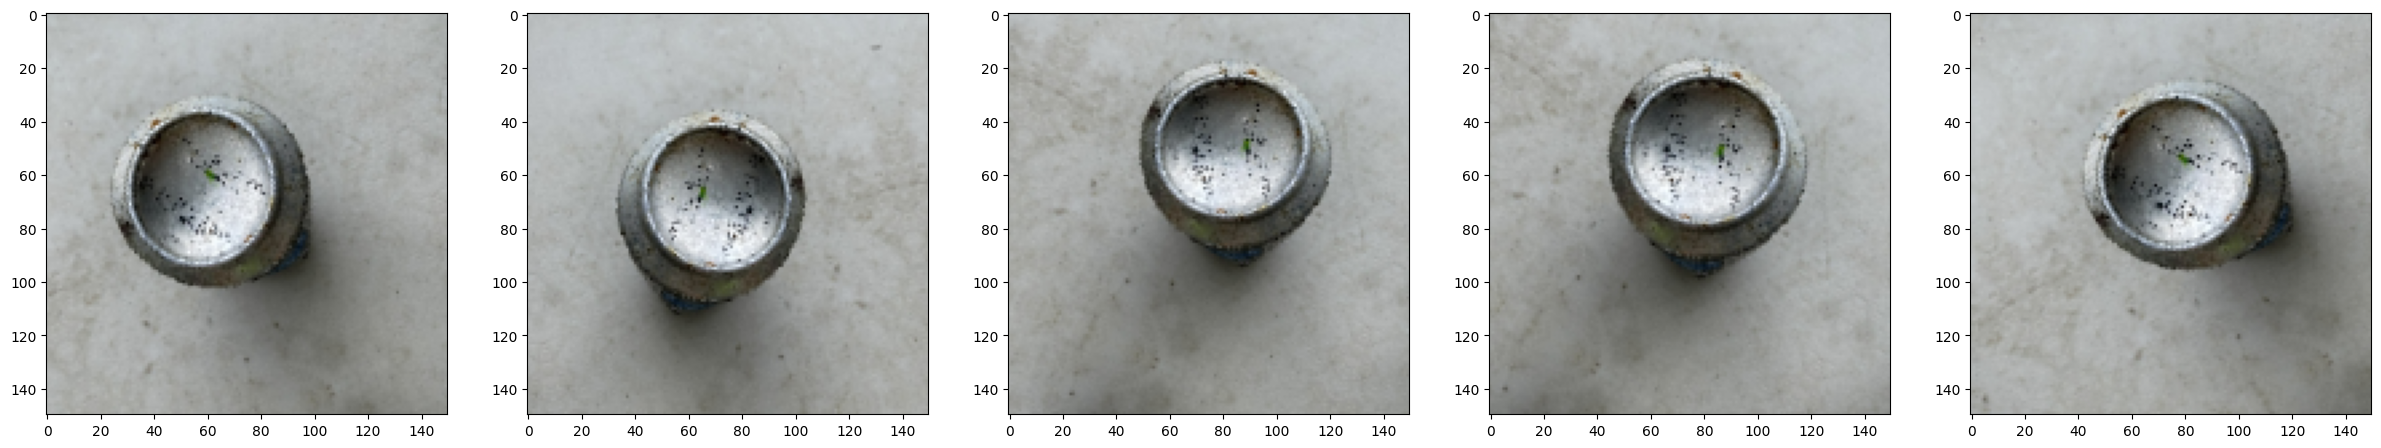

In [70]:
plt.figure()
f, axarr = plt.subplots(1, 5, figsize=(30, 8))

for i in range(5):
  axarr[i].imshow(train_generator[0][0][0])

### Definición del modelo

In [71]:
model = Sequential([
    Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=2),

    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),

    Flatten(),

    Dense(32, activation='relu'),

    BatchNormalization(),

    Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 75, 75, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 37, 37, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_4 (Flatten)         (None, 43808)             0         
                                                                 
 dense_8 (Dense)             (None, 32)               

### Entrenamiento del modelo

In [72]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

Epoch 1/10
44/44 [==============================] - 90s 2s/step - loss: 1.3252 - accuracy: 0.4968 - val_loss: 2.8156 - val_accuracy: 0.1600
Epoch 2/10
44/44 [==============================] - 86s 2s/step - loss: 1.1214 - accuracy: 0.5886 - val_loss: 2.3424 - val_accuracy: 0.2943
Epoch 3/10
44/44 [==============================] - 87s 2s/step - loss: 1.0200 - accuracy: 0.6357 - val_loss: 1.5988 - val_accuracy: 0.5286
Epoch 4/10
44/44 [==============================] - 92s 2s/step - loss: 0.9572 - accuracy: 0.6479 - val_loss: 2.4232 - val_accuracy: 0.3571
Epoch 5/10
44/44 [==============================] - 93s 2s/step - loss: 0.9431 - accuracy: 0.6464 - val_loss: 1.8870 - val_accuracy: 0.3800
Epoch 6/10
44/44 [==============================] - 89s 2s/step - loss: 0.8585 - accuracy: 0.6954 - val_loss: 0.8533 - val_accuracy: 0.6971
Epoch 7/10
44/44 [==============================] - 85s 2s/step - loss: 0.8319 - accuracy: 0.6889 - val_loss: 1.2219 - val_accuracy: 0.5629
Epoch 8/10
44/44 [==

### Gráfico de métricas para los conjuntos train y validation

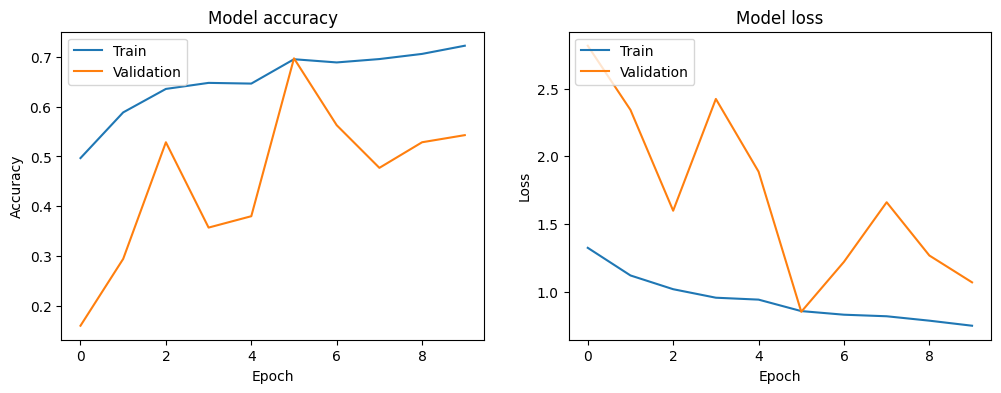

In [73]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

### Predicciones con el modelo actual

2/2 [==============================] - 0s 162ms/step


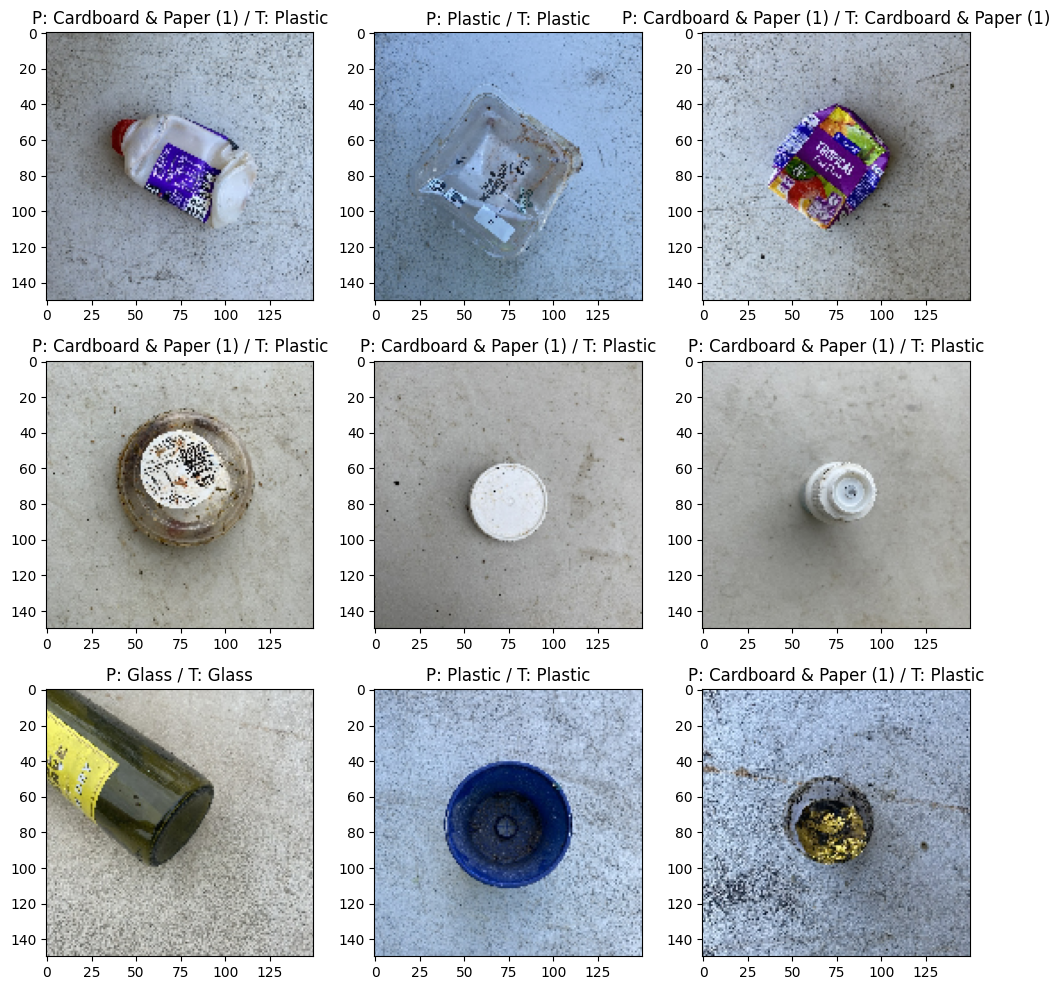

In [80]:
test_x, test_y = validation_generator.__getitem__(1)

predictions = model.predict(test_x)

plt.figure(figsize=(10, 10))

# Iterar sobre las primeras 9 imágenes y predicciones
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.title('P: %s / T: %s' % (labels[np.argmax(predictions[i])], labels[np.argmax(test_y[i])]))
    plt.imshow(test_x[i])
    plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.tight_layout()
plt.show()

### Matriz de confusión

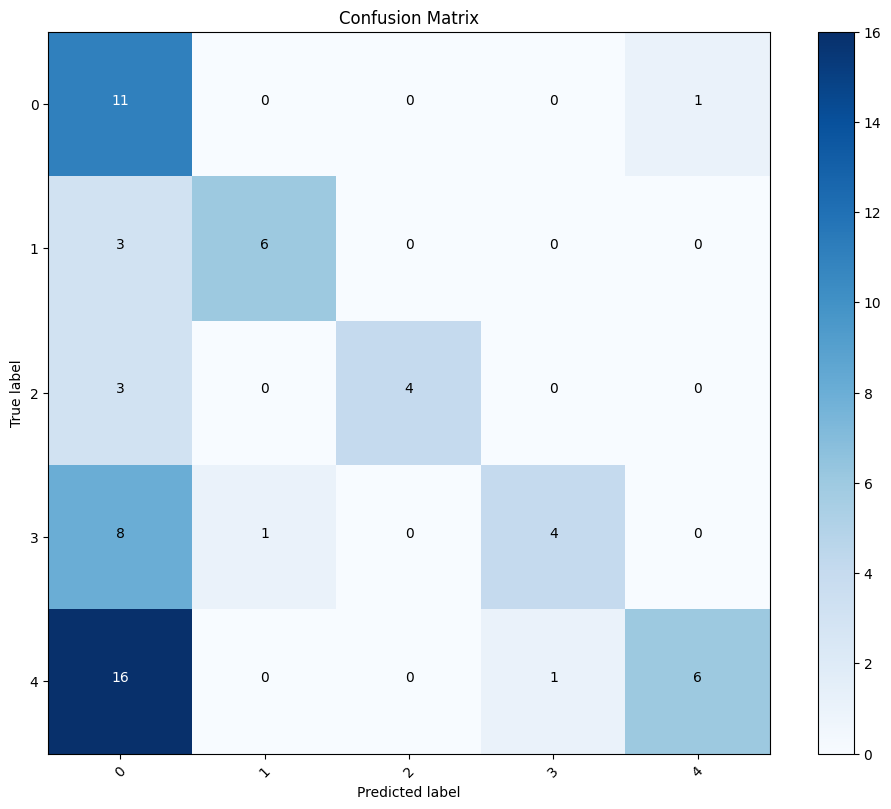

In [82]:
# Función para graficar la matriz de confusión
def plot_confusion_matrix(confusion_matrix, labels):
    plt.figure(figsize=(10, 8))
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    thresh = confusion_matrix.max() / 2.
    for i in range(len(labels)):
        for j in range(len(labels)):
            plt.text(j, i, format(confusion_matrix[i][j], 'd'),
                     horizontalalignment="center",
                     color="white" if confusion_matrix[i][j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Calcular la matriz de confusión
confusion_matrix = np.zeros((len(labels), len(labels)), dtype=int)
for pred, true_label in zip(predictions, test_y):
    pred_index = np.argmax(pred)
    true_index = np.argmax(true_label)
    confusion_matrix[true_index][pred_index] += 1

plot_confusion_matrix(confusion_matrix, labels)
plt.show()